* give reason for dropping live, canceled and suspended state

In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

In [2]:
def prepForModel(df):
    drop_cols = [
        'blurb',
        'creator',
        'currency',
        'currency_trailing_code',
        'fx_rate',
        'location',
        'name',
        'profile',
        'slug',
        'source_url',
        'static_usd_rate',
        'usd_type',
        'spotlight'
    ]
    df.drop(drop_cols, inplace=True, axis = 1)
    for c in df.columns: 
        if df[c].dtype == "object": 
            df[c] = df[c].astype("category") 
    df.dropna(inplace=True)
    return df

In [3]:
df = pd.read_csv('data/df_clean.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df[(df['state']=='failed') | (df['state']=='successful')]

In [4]:
df = prepForModel(df)

In [5]:
df.head()

,backers_count,converted_pledged_amount,country,created_at,deadline,disable_communication,goal,is_starrable,launched_at,pledged,staff_pick,state,state_changed_at,usd_pledged,category_name,category_slug,cgrouped
0,2,2,CA,1540305218,1542900780,False,30000.0,False,1540308166,3.29,False,failed,1542900780,2.513164,Web,journalism/web,CA
1,2,2,US,1462569183,1471994797,False,70000.0,False,1468106797,2.00,False,failed,1471994797,2.000000,Drama,film & video/drama,US
2,119,5635,US,1483369959,1487595600,False,4000.0,False,1486386355,5635.00,False,successful,1487595600,5635.000000,Restaurants,food/restaurants,US
3,70,1317,US,1325637522,1331530353,False,500.0,False,1329719553,1317.69,False,successful,1331530353,1317.690000,Graphic Design,design/graphic design,US
4,73,5134,US,1301344770,1306558117,False,5000.0,False,1303102117,5134.01,False,successful,1306558117,5134.010000,Poetry,publishing/poetry,US


### Create new timestamp features

In [6]:
df['delta_create_deadline'] = df['deadline'] - df['created_at']
df['delta_create_launch'] = df['launched_at'] - df['created_at']
df['delta_create_change'] = df['state_changed_at'] - df['created_at']
df['delta_launch_deadline'] = df['deadline'] - df['launched_at']
df['delta_change_launch'] = df['state_changed_at'] - df['launched_at']
df['delta_deadline_change'] = df['deadline'] - df['launched_at']

In [7]:
from datetime import datetime
def timeline(t, m='dt'):
    if m == 'days':
        return t/24/60/60
    elif m == 'months':
        return t/24/60/60/30.4167
    elif m == 'year':
        return t/24/60/60/30.4167/12 + 1970
    elif m == 'dt':
        return datetime.fromtimestamp(t)
def toDay(time_delta):
    return round(time_delta/3600/24,2)
def toDateMonth(time_delta):
    return (datetime.fromtimestamp(time_delta)).month

In [8]:
df.drop(columns=['created_at','deadline','launched_at','state_changed_at','country','category_name','cgrouped'], axis=1, inplace=True)

In [9]:
df.delta_create_deadline=toDay(df.delta_create_deadline)
df.delta_create_launch=toDay(df.delta_create_launch)
df.delta_create_change=toDay(df.delta_create_change)
df.delta_launch_deadline=toDay(df.delta_launch_deadline)
df.delta_change_launch=toDay(df.delta_change_launch)
df.delta_deadline_change=toDay(df.delta_deadline_change)

In [10]:
df.head()

,backers_count,converted_pledged_amount,disable_communication,goal,is_starrable,pledged,staff_pick,state,usd_pledged,category_slug,delta_create_deadline,delta_create_launch,delta_create_change,delta_launch_deadline,delta_change_launch,delta_deadline_change
0,2,2,False,30000.0,False,3.29,False,failed,2.513164,journalism/web,30.04,0.03,30.04,30.01,30.01,30.01
1,2,2,False,70000.0,False,2.00,False,failed,2.000000,film & video/drama,109.09,64.09,109.09,45.00,45.00,45.00
2,119,5635,False,4000.0,False,5635.00,False,successful,5635.000000,food/restaurants,48.91,34.91,48.91,14.00,14.00,14.00
3,70,1317,False,500.0,False,1317.69,False,successful,1317.690000,design/graphic design,68.20,47.25,68.20,20.96,20.96,20.96
4,73,5134,False,5000.0,False,5134.01,False,successful,5134.010000,publishing/poetry,60.34,20.34,60.34,40.00,40.00,40.00


In [11]:
#sns.pairplot(df, hue='state')

have a deeper look at following time feature correlation:
* all deltas - disable_communication (suspended vs other states)
* all deltas - goal (successful vs other states)
* delta_change_launch - is_starrable
* all deltas - backers_count
* all deltas - converted_pledged_amount

<AxesSubplot:xlabel='disable_communication', ylabel='count'>

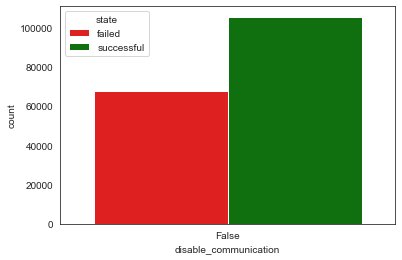

In [11]:
sns.set_style('white')
sns.countplot(x=df.disable_communication, hue=df.state, palette={"failed": "red", "successful": "green"})

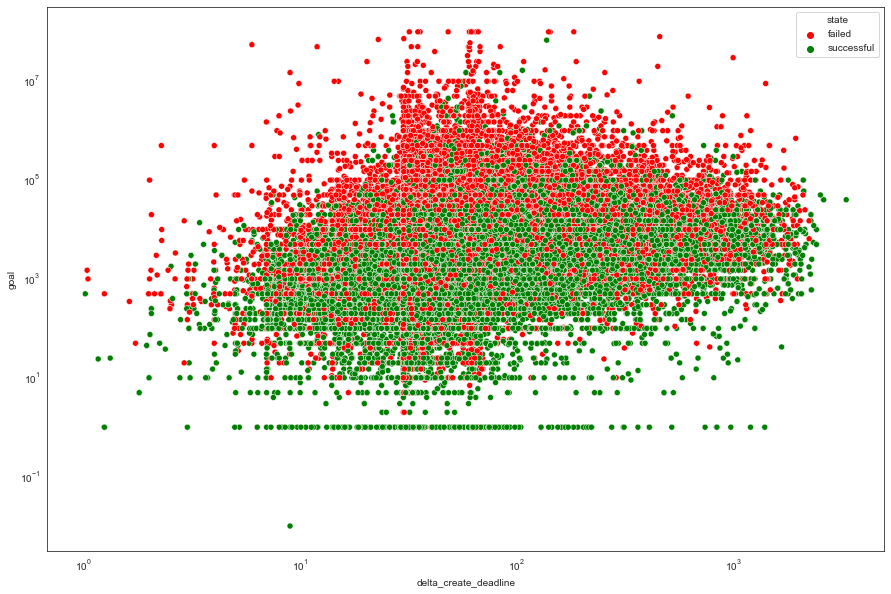

In [13]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_create_deadline', y='goal', hue='state', palette={"failed": "red", "successful": "green"})
plt.yscale('log')
plt.xscale('log')

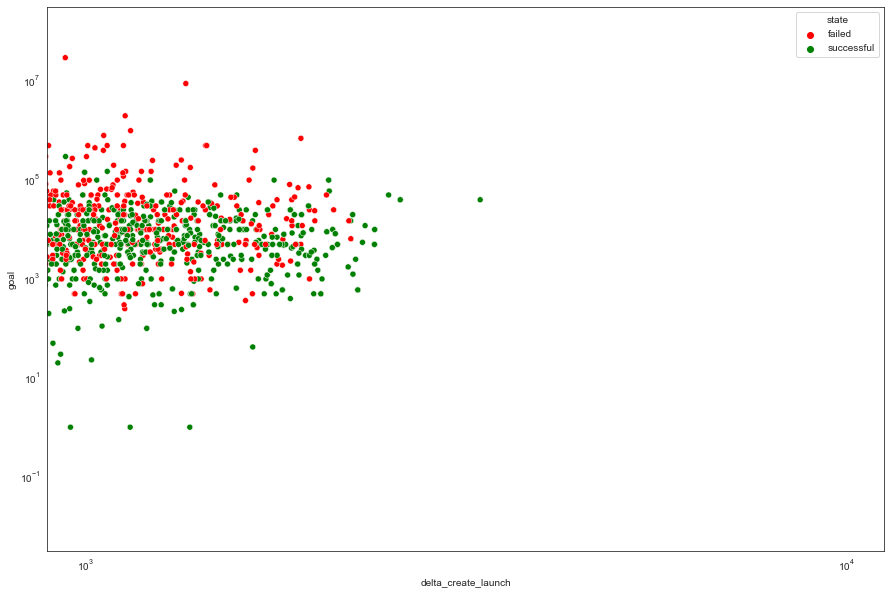

In [14]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_create_launch', y='goal', hue='state', palette={"failed": "red", "successful": "green"})
plt.yscale('log')
plt.xscale('log')

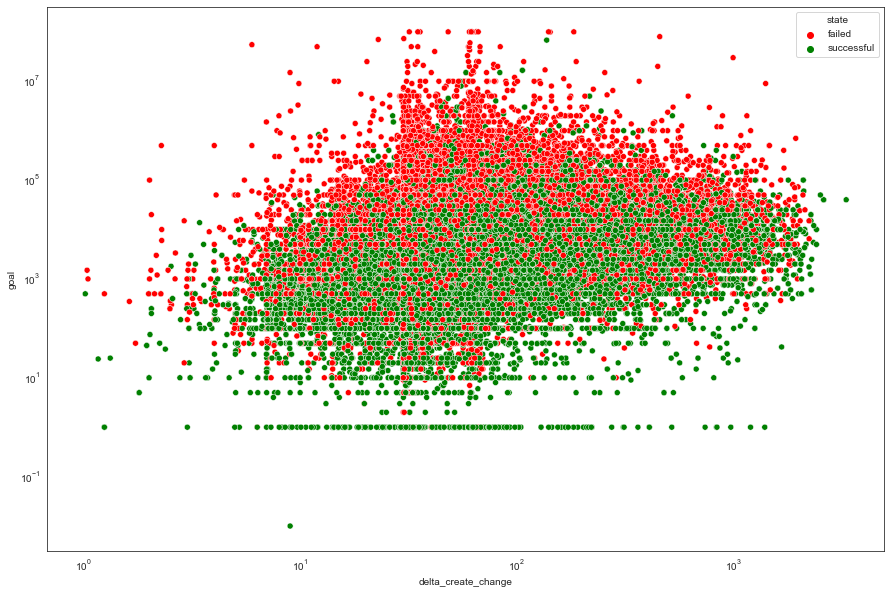

In [15]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_create_change', y='goal', hue='state', palette={"failed": "red", "successful": "green"})
plt.yscale('log')
plt.xscale('log')

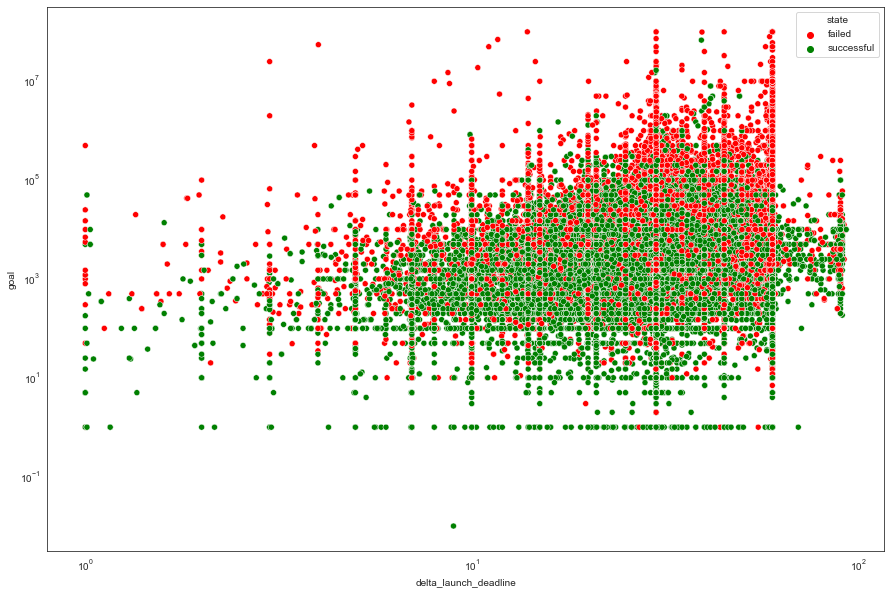

In [16]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_launch_deadline', y='goal', hue='state', palette={"failed": "red", "successful": "green"})
plt.yscale('log')
plt.xscale('log')

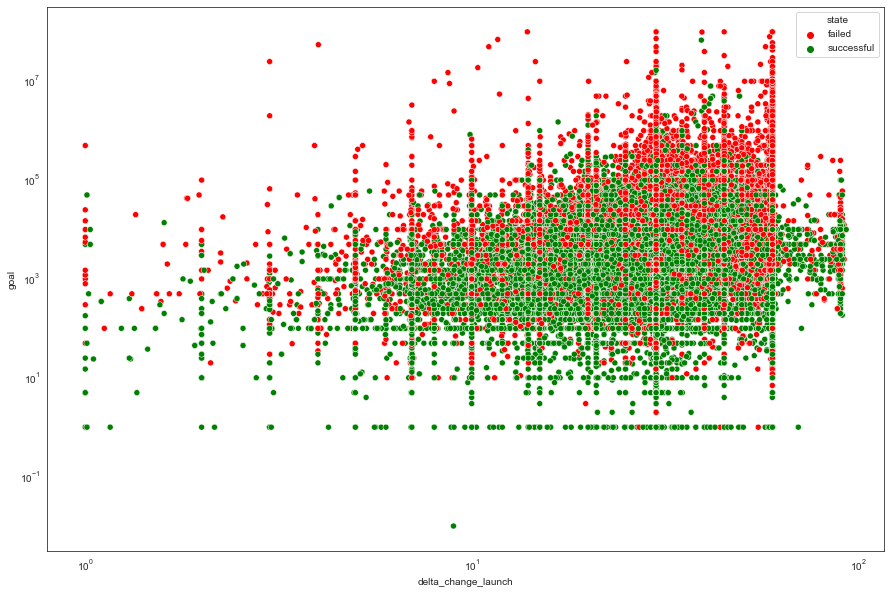

In [17]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_change_launch', y='goal', hue='state', palette={"failed": "red", "successful": "green"})
plt.yscale('log')
plt.xscale('log')

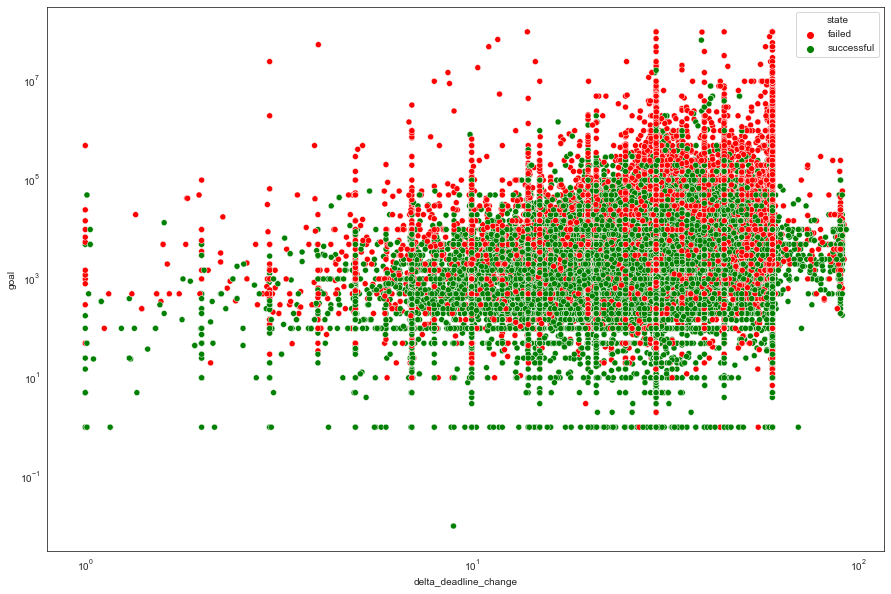

In [18]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='delta_deadline_change', y='goal', hue='state', palette={"failed": "red", "successful": "green"})
plt.yscale('log')
plt.xscale('log')

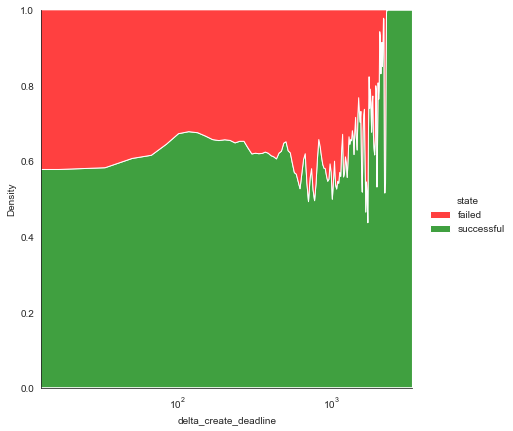

In [19]:
sns.displot(data=df, x='delta_create_deadline', hue='state', kind="kde", height=6, multiple="fill", clip=(0, None), palette={"failed": "red", "successful": "green"})
plt.xscale('log')

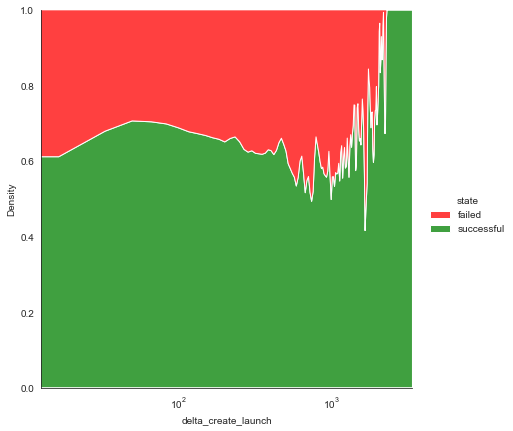

In [20]:
sns.displot(data=df, x='delta_create_launch', hue='state', kind="kde", height=6, multiple="fill", clip=(0, None), palette={"failed": "red", "successful": "green"});
plt.xscale('log')

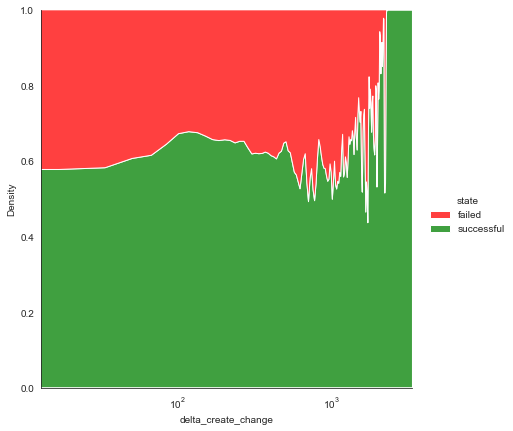

In [21]:
sns.displot(data=df, x='delta_create_change', hue='state', kind="kde", height=6, multiple="fill", clip=(0, None), palette={"failed": "red", "successful": "green"});
plt.xscale('log')

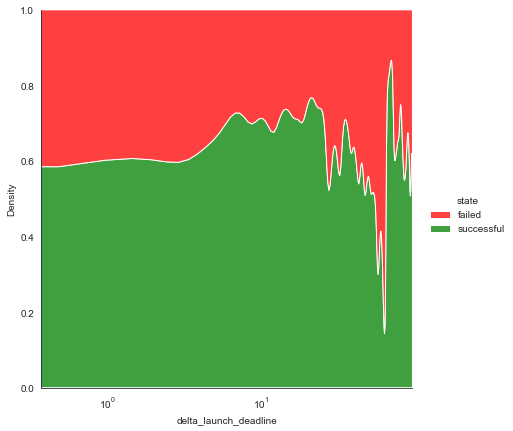

In [22]:
sns.displot(data=df, x='delta_launch_deadline', hue='state', kind="kde", height=6, multiple="fill", clip=(0, None), palette={"failed": "red", "successful": "green"});
plt.xscale('log')

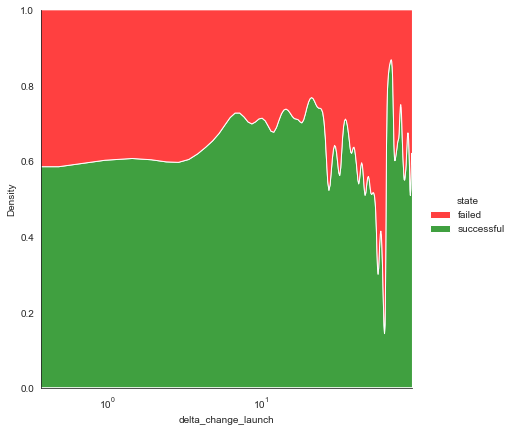

In [23]:
sns.displot(data=df, x='delta_change_launch', hue='state', kind="kde", height=6, multiple="fill", clip=(0, None), palette={"failed": "red", "successful": "green"});
plt.xscale('log')

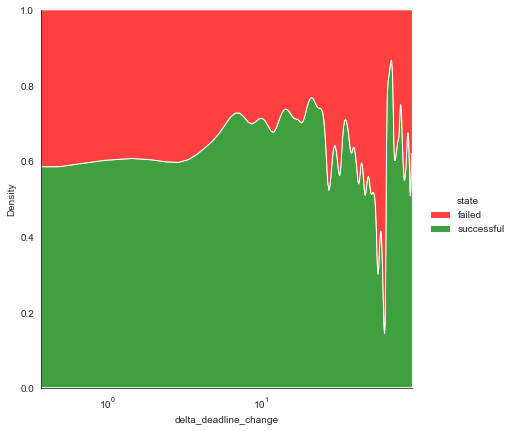

In [24]:
sns.displot(data=df, x='delta_deadline_change', hue='state', kind="kde", height=6, multiple="fill", clip=(0, None), palette={"failed": "red", "successful": "green"});
plt.xscale('log')

In [25]:
M = pd.crosstab(df.delta_change_launch, df.is_starrable)
M

is_starrable,False
delta_change_launch,
1.00,24
1.01,5
1.02,1
1.03,3
1.05,1
...,...
90.96,29
91.00,6
91.96,1


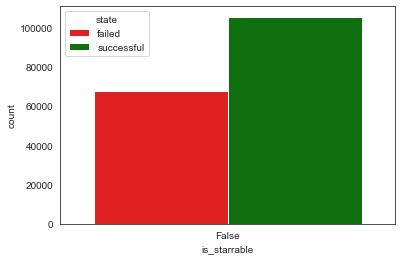

In [26]:
sns.countplot(x=df.is_starrable, hue=df.state, palette={"failed": "red", "successful": "green"});

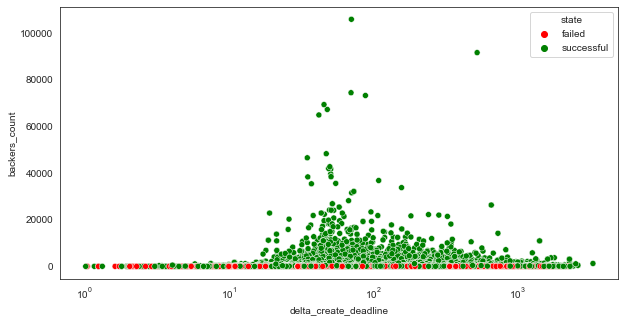

In [27]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_create_deadline', y='backers_count', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

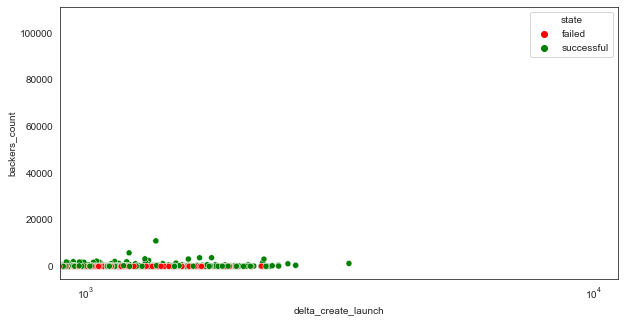

In [28]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_create_launch', y='backers_count', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

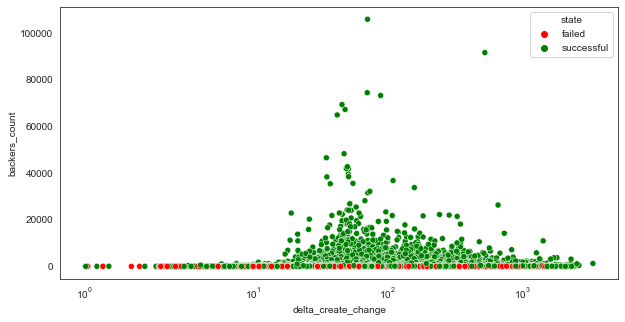

In [29]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_create_change', y='backers_count', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('symlog')

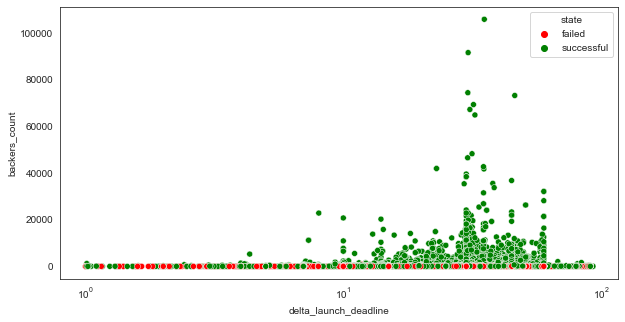

In [30]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_launch_deadline', y='backers_count', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

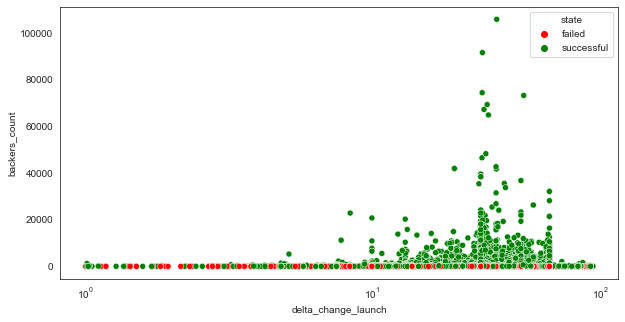

In [31]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_change_launch', y='backers_count', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('symlog')

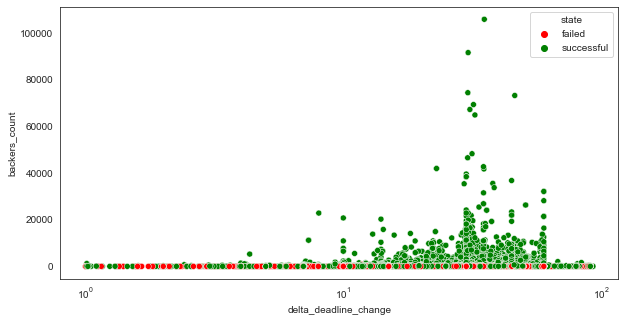

In [32]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='delta_deadline_change', y='backers_count', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

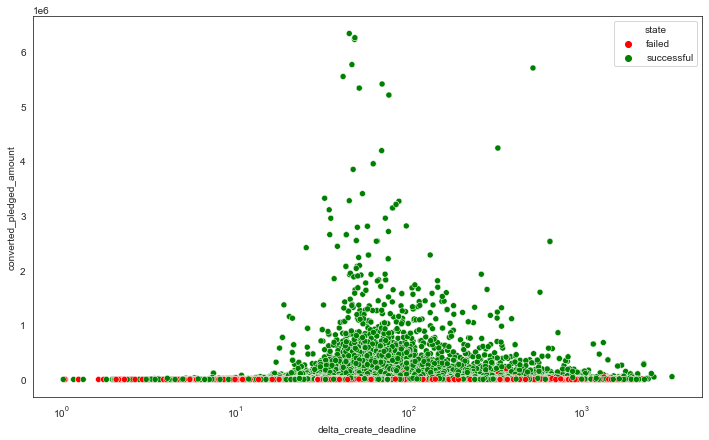

In [33]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_create_deadline', y='converted_pledged_amount', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

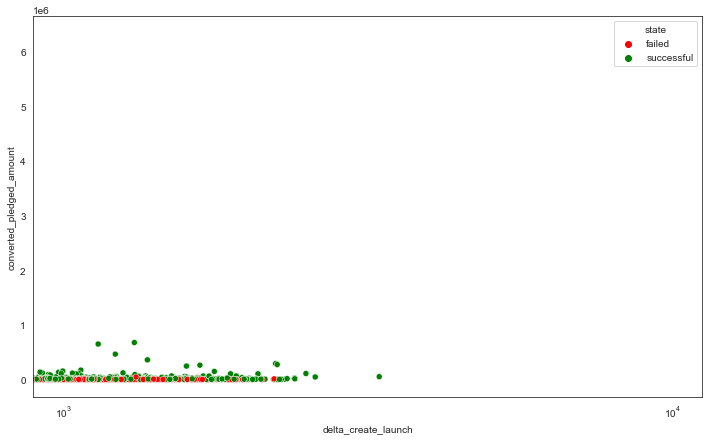

In [34]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_create_launch', y='converted_pledged_amount', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

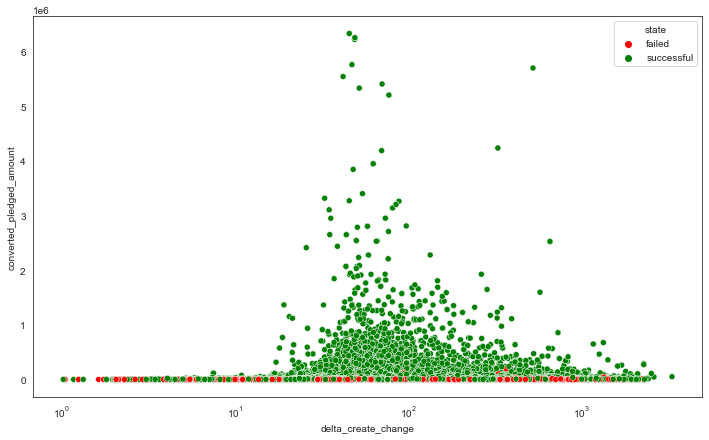

In [35]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_create_change', y='converted_pledged_amount', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

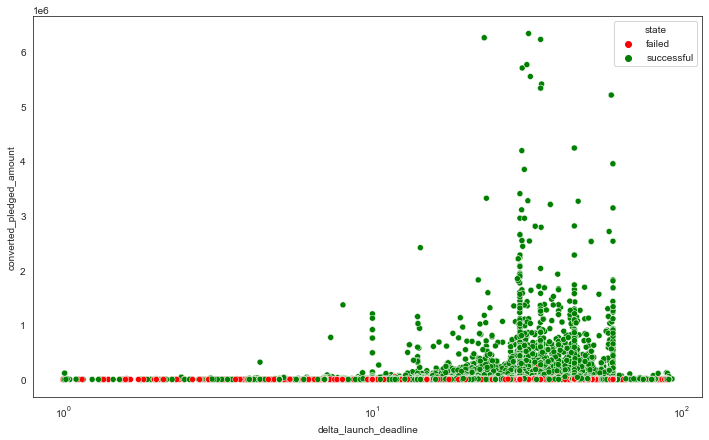

In [36]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_launch_deadline', y='converted_pledged_amount', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

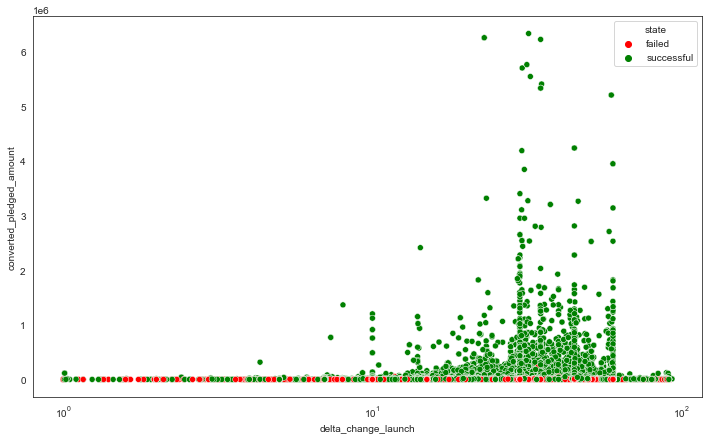

In [37]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_change_launch', y='converted_pledged_amount', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

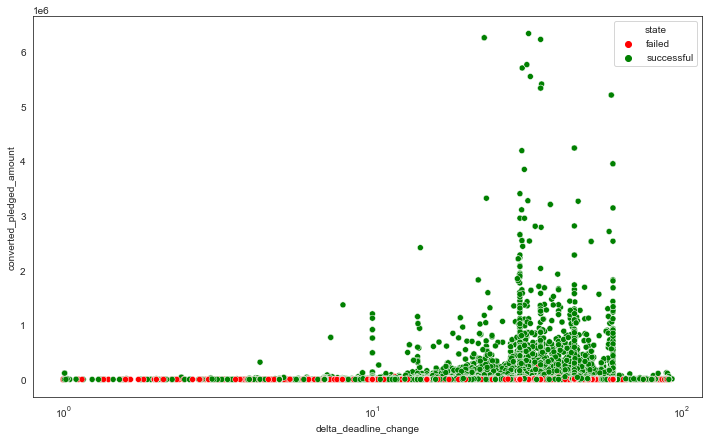

In [38]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=df, x='delta_deadline_change', y='converted_pledged_amount', hue='state', palette={"failed": "red", "successful": "green"})
#plt.yscale('log')
plt.xscale('log')

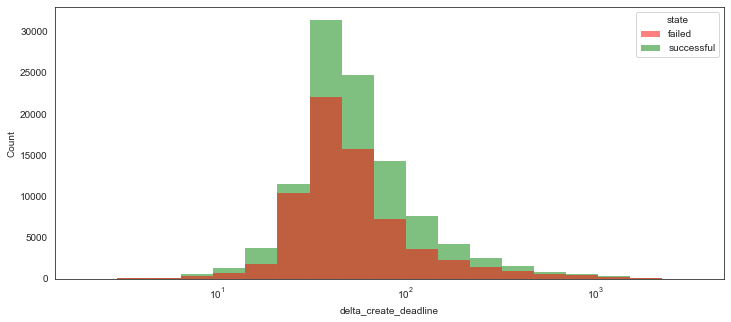

In [39]:
plt.figure(figsize=(12,5))
LogMin, LogMax = np.log10(df['delta_create_deadline'].min()+1.),np.log10(df['delta_create_deadline'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.histplot(data=df, x='delta_create_deadline', hue='state', palette={"failed": "red", "successful": "green"}, bins=newBins)
plt.xscale('log')

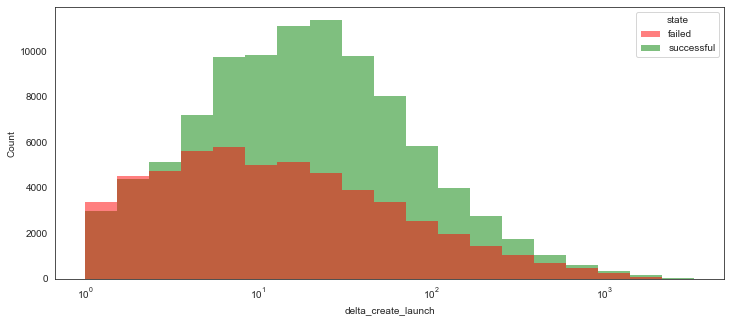

In [40]:
plt.figure(figsize=(12,5))
LogMin, LogMax = np.log10(df['delta_create_launch'].min()+1.),np.log10(df['delta_create_launch'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.histplot(data=df, x='delta_create_launch', hue='state', palette={"failed": "red", "successful": "green"}, bins=newBins)
plt.xscale('log')

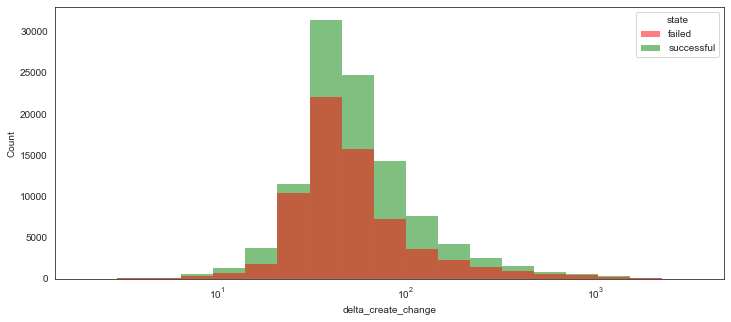

In [41]:
plt.figure(figsize=(12,5))
LogMin, LogMax = np.log10(df['delta_create_change'].min()+1.),np.log10(df['delta_create_change'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.histplot(data=df, x='delta_create_change', hue='state', palette={"failed": "red", "successful": "green"}, bins=newBins)
plt.xscale('log')

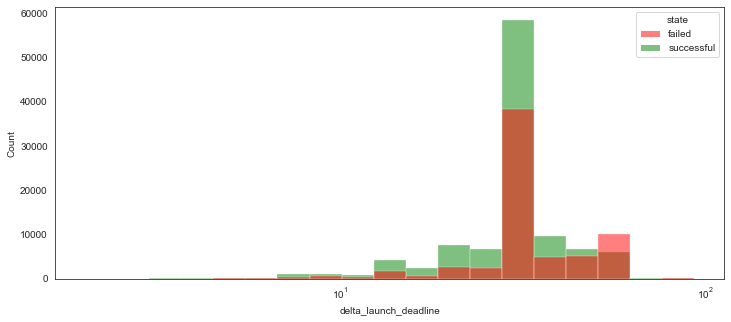

In [42]:
plt.figure(figsize=(12,5))
LogMin, LogMax = np.log10(df['delta_launch_deadline'].min()+1.),np.log10(df['delta_launch_deadline'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.histplot(data=df, x='delta_launch_deadline', hue='state', palette={"failed": "red", "successful": "green"}, bins=newBins)
plt.xscale('log')

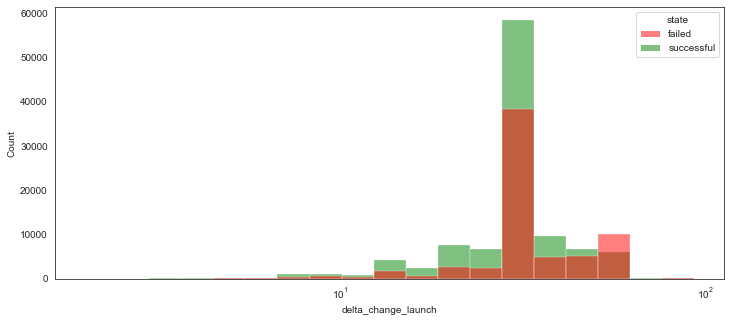

In [43]:
plt.figure(figsize=(12,5))
LogMin, LogMax = np.log10(df['delta_change_launch'].min()+1.),np.log10(df['delta_change_launch'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.histplot(data=df, x='delta_change_launch', hue='state', palette={"failed": "red", "successful": "green"}, bins=newBins)
plt.xscale('log')

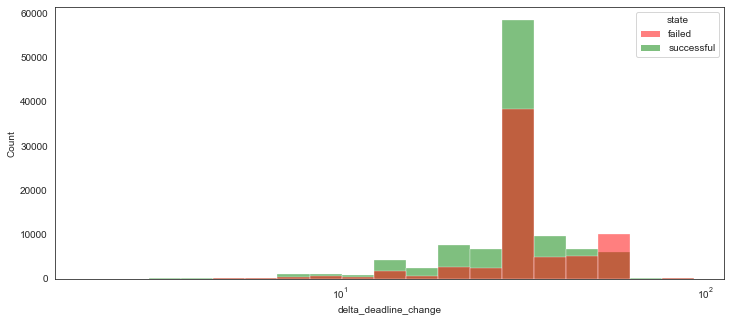

In [44]:
plt.figure(figsize=(12,5))
LogMin, LogMax = np.log10(df['delta_deadline_change'].min()+1.),np.log10(df['delta_deadline_change'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.histplot(data=df, x='delta_deadline_change', hue='state', palette={"failed": "red", "successful": "green"}, bins=newBins)
plt.xscale('log')

KeyboardInterrupt: 

<Figure size 1080x720 with 0 Axes>

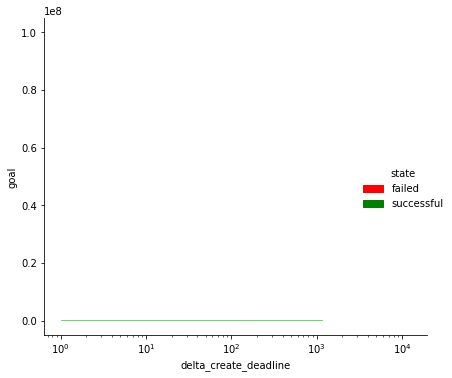

In [11]:
plt.figure(figsize=(15,10))
LogMin, LogMax = np.log10(df['delta_create_deadline'].min()),np.log10(df['delta_create_deadline'].max())
newBins = np.logspace(LogMin, LogMax,20)
sns.displot(df, x="delta_create_deadline", y="goal", hue="state",
            palette={"failed": "red", "successful": "green"},
            log_scale=(True, False),
            binwidth=newBins,
           )
plt.xscale('log')
#plt.yscale('log')

In [46]:
df_m = pd.read_csv('data/df_clean.csv')
df_m.drop(df_m.columns[df_m.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_m = df_m[(df_m['state']=='failed') | (df_m['state']=='successful')]

In [47]:
df_m = prepForModel(df_m)

In [48]:
df_m.created_at=df_m.created_at.apply(toDateMonth)
df_m.launched_at=df_m.launched_at.apply(toDateMonth)
df_m.state_changed_at=df_m.state_changed_at.apply(toDateMonth)
df_m.deadline=df_m.deadline.apply(toDateMonth)

In [49]:
M = pd.crosstab(df_m.created_at, df_m.state)
M

state,failed,successful
created_at,,
1,5791,9819
2,5347,8525
3,5571,9586
4,5527,8924
5,5727,9241
6,5623,8347
7,7367,9069
8,5950,9217
9,5467,9010


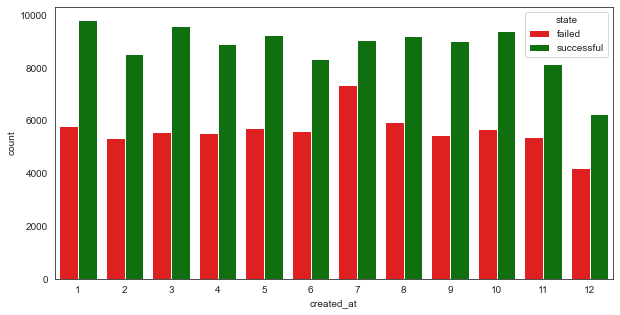

In [50]:
plt.figure(figsize=(10,5))
sns.countplot(x=df_m.created_at, hue=df_m.state, palette={"failed": "red", "successful": "green"});

In [51]:
df_y = pd.read_csv('data/df_clean.csv')
df_y.drop(df_y.columns[df_y.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df_y = prepForModel(df_y)

from datetime import datetime
def timeline(t, m='dt'):
    if m == 'days':
        return int(t/24/60/60)
    elif m == 'months':
        return int(t/24/60/60/30.4167)
    elif m == 'year':
        return int(t/24/60/60/30.4167/12) + 1970
    elif m == 'dt':
        return datetime.fromtimestamp(t)

for i in range(len(df_y.created_at)):
    a = datetime.fromtimestamp(df_y.created_at[i])
    df_y.created_at[i]=a.year
for i in range(len(df_y.launched_at)):
    a = datetime.fromtimestamp(df_y.launched_at[i])
    df_y.launched_at[i]=a.year
for i in range(len(df_y.state_changed_at)):
    a = datetime.fromtimestamp(df_y.state_changed_at[i])
    df_y.state_changed_at[i]=a.year
for i in range(len(df_y.deadline)):
    a = datetime.fromtimestamp(df_y.deadline[i])
    df_y.deadline[i]=a.year

<ipython-input-51-422bed200091>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.created_at[i]=a.year
<ipython-input-51-422bed200091>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.launched_at[i]=a.year
<ipython-input-51-422bed200091>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.state_changed_at[i]=a.year
<ipython-input-51-422bed200091>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [52]:
df_y = df_y[(df_y['state']=='failed') | (df_y['state']=='successful')]

In [53]:
df_y.state.unique()

['failed', 'successful']
Categories (2, object): ['failed', 'successful']

In [54]:
Year = pd.crosstab(df_y.created_at, df_y.state)
Year

state,failed,successful
created_at,,
2009,33,136
2010,263,919
2011,845,3158
2012,1970,6818
2013,2426,8529
2014,11984,13515
2015,17391,14994
2016,12440,13232
2017,11491,15798


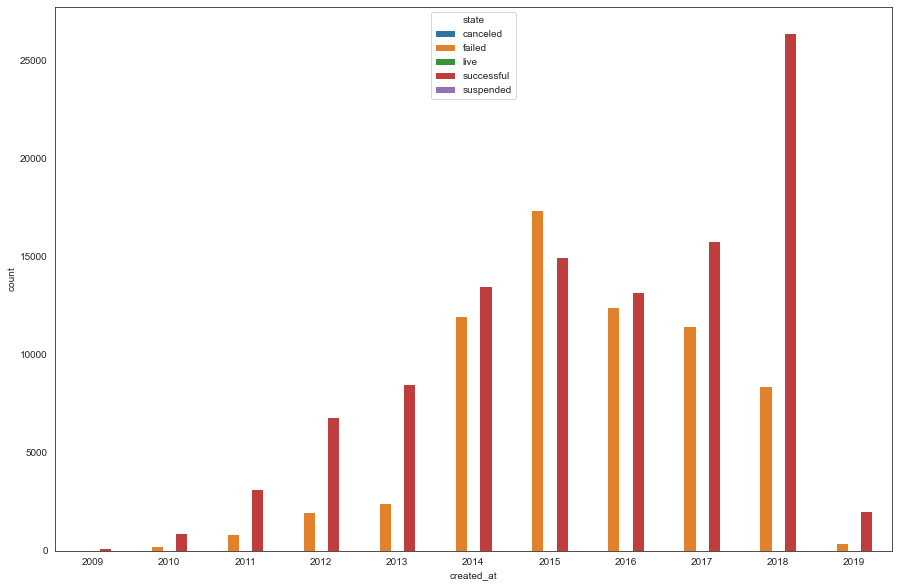

In [55]:
plt.figure(figsize=(15,10))
sns.countplot(data=df_y, x='created_at', hue='state');

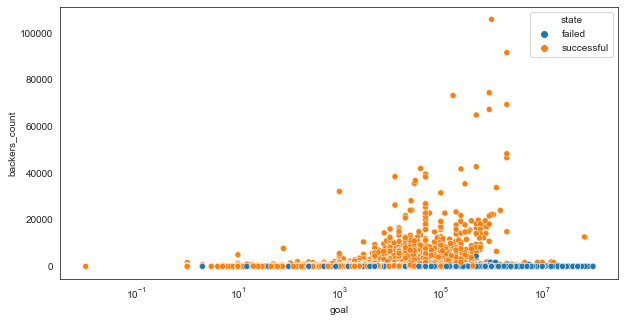

In [56]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='goal', y='backers_count', hue='state')
#plt.yscale('log')
plt.xscale('log')

#### feature engineering

* drop outliers:

In [57]:
#Dropping the outlier rows with standard deviation
factor = 3
upper_lim = data['column'].mean () + data['column'].std () * factor
lower_lim = data['column'].mean () - data['column'].std () * factor

data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)

SyntaxError: unexpected EOF while parsing (<ipython-input-57-0263a48504ce>, line 6)

In [ ]:
#Dropping the outlier rows with Percentiles
upper_lim = data['column'].quantile(.95)
lower_lim = data['column'].quantile(.05)

data = data[(data['column'] < upper_lim) & (data['column'] > lower_lim)]

* log transformation on
  - goal
  - timestamp deltas
  - other skewed data from pandas profiling

In [ ]:
a = df.goal
len(a)

In [ ]:
sns.boxplot(a)

In [ ]:
upper_lim = a.quantile(.90)
#lower_lim = a.quantile(.05)

b = df[(df['goal'] < upper_lim) & (df['goal'] > 0)]

In [ ]:
len(b)

In [ ]:
len(b)/len(a)

In [ ]:
sns.boxplot(b.goal)